In [1]:
# importing modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

import emcee
import corner

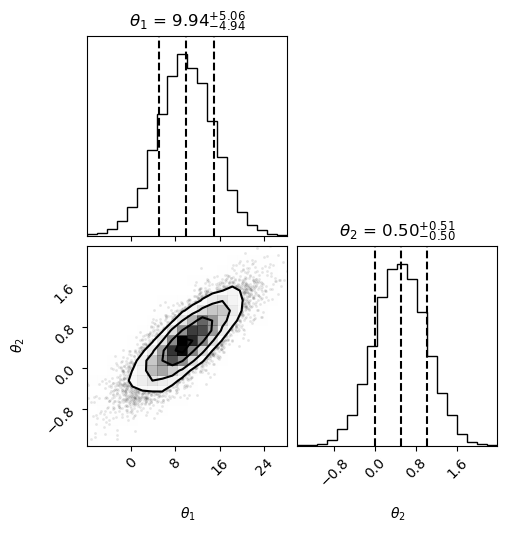

In [2]:
# Sample code to make a corner plot with dashed lines indicating 16%, 50%, 84% quantiles
# i.e. showing the median and the 68% equal-tail interval

# Samples from a correlated, bivariate normal distribution
my_mean = np.array([10., 0.5])
my_cov = np.array([[25., 2.0],[2.0,0.25]])
my_rv = stats.multivariate_normal(mean=my_mean, cov=my_cov)

mysamples = my_rv.rvs(size=10000)

import corner
corner.corner(mysamples,labels=[r"$\theta_1$", r"$\theta_2$"],show_titles=True,
                       quantiles=[0.16, 0.5, 0.84],);

In [23]:
def rolling_moments(chain,lag=4000):
    chain_lag = np.lib.stride_tricks.sliding_window_view(chain, lag)
    rollmean = chain_lag.mean(axis=-1)
    rollstd = chain_lag.std(axis=-1)
    nan_lag = np.nan*np.ones(lag)
    return (np.concatenate((nan_lag, rollmean)), np.concatenate((nan_lag, rollstd)))

In [46]:
def trace_plots(chain1, chain2, title_str = '', lag=4000):
    ncols = 2
    (nsamples,npars) = chain1.shape
    fig,axs = plt.subplots(nrows=npars, ncols=ncols, sharex=True, sharey='row')
    for ipar in range(npars):
        for ichain, chain in enumerate([chain1, chain2]):
            ax=axs[ipar, ichain]
            ax.plot(chain[:,ipar])
            (rollmean, rollstd) = rolling_moments(chain[:,ipar],lag=lag)
            ax.plot(rollmean,'r-',label='roll. mean')
            ax.plot(rollmean+rollstd,'r--',label='roll. std')
            ax.plot(rollmean-rollstd,'r--')
            axs[1,ichain].set_xlabel('iteration');
            axs[0,ichain].set_title(f'chain {ichain} {title_str}')
        axs[ipar,0].set_ylabel(rf'$\theta_{ipar}$')
    axs[1,1].legend(loc='best');

### `scipy.stats` samples

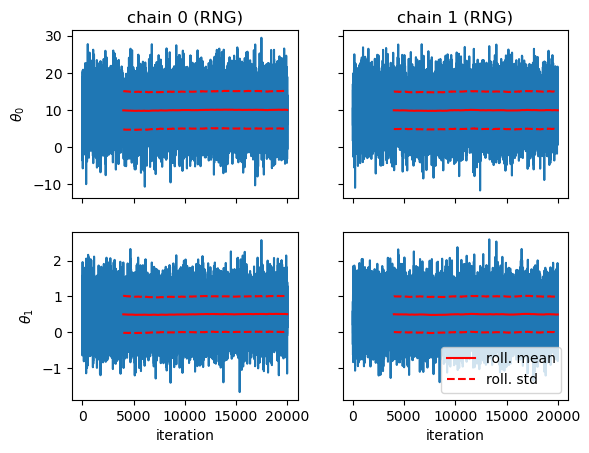

In [47]:
Nsamples = 20000
mysamples1 = my_rv.rvs(size=Nsamples)
mysamples2 = my_rv.rvs(size=Nsamples)
trace_plots(mysamples1, mysamples2, title_str = '(RNG)')

### Metropolis sampling

In [48]:
my_proposal_widths = [0.1, 2., 50.]

In [60]:
init = np.random.randn(4, 2)
nwalkers, ndim = init.shape
Nsamples = 20000
lag = 5000

initializing and running Metropolis sampler for proposal width = 0.1
...the average acceptance ratio is 0.89388
initializing and running Metropolis sampler for proposal width = 2.0
...the average acceptance ratio is 0.175925
initializing and running Metropolis sampler for proposal width = 50.0
...the average acceptance ratio is 0.00117


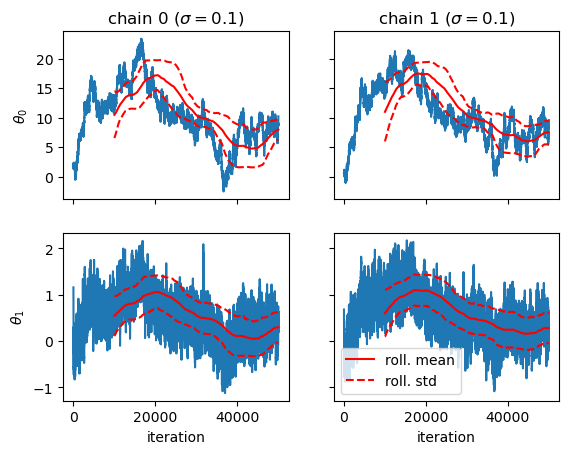

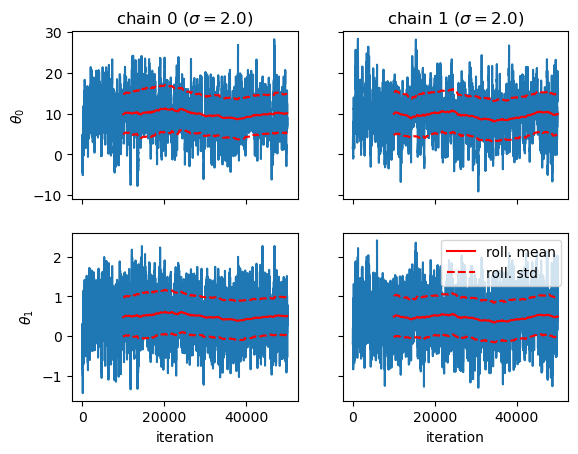

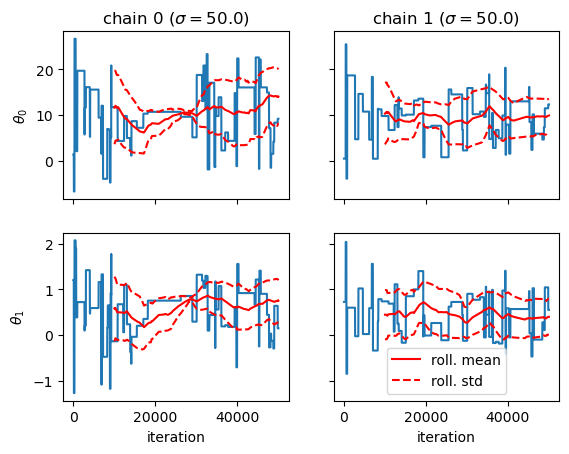

In [50]:
for my_proposal_width in my_proposal_widths:
    print(f'initializing and running Metropolis sampler for proposal width = {my_proposal_width}')
    samplerM = emcee.EnsembleSampler(nwalkers, ndim, my_rv.logpdf, moves=emcee.moves.GaussianMove(np.eye(ndim)*my_proposal_width**2))
    samplerM.run_mcmc(init, Nsamples)
    samplesM = samplerM.get_chain()
    print(f'...the average acceptance ratio is {samplerM.acceptance_fraction.mean()}')
    #print('The estimated autocorrelation time is:')
    #print(samplerM.acor)
    trace_plots(samplesM[:,0,:], samplesM[:,1,:], title_str = rf'($\sigma={my_proposal_width}$)', lag=lag)

### Ensemble sampler with affine-invariant stretch move

In [51]:
# Ensamble sampler with affine-invariant stretch move
samplerStretch = emcee.EnsembleSampler(nwalkers, ndim, my_rv.logpdf)
samplerStretch.run_mcmc(init, Nsamples);
samplesStretch = samplerStretch.get_chain()

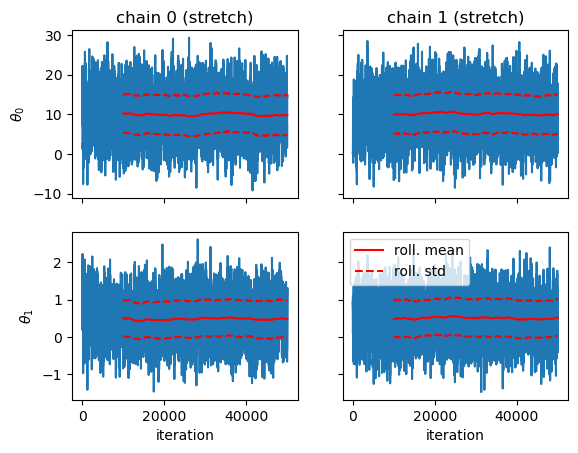

In [52]:
trace_plots(samplesStretch[:,0,:], samplesStretch[:,1,:], title_str = rf'(stretch)', lag=lag)

### Secret distribution

In [55]:
from scipy.signal import convolve

In [64]:
secret_mean1 = np.array([1.0, 2.0])
secret_cov1 = np.array([[1., 0.25],[0.25,0.25]])
secret_mean2 = np.array([1.5, -2.5])
secret_cov2 = np.array([[1., -0.25],[-0.25,0.25]])
def logpdf_secret(theta):
    return 0.5 * stats.multivariate_normal(mean=secret_mean1, cov=secret_cov1).logpdf(theta) \
        + 0.5 * stats.multivariate_normal(mean=secret_mean2, cov=secret_cov2).logpdf(theta)

...the average acceptance ratio is 0.9112625000000001


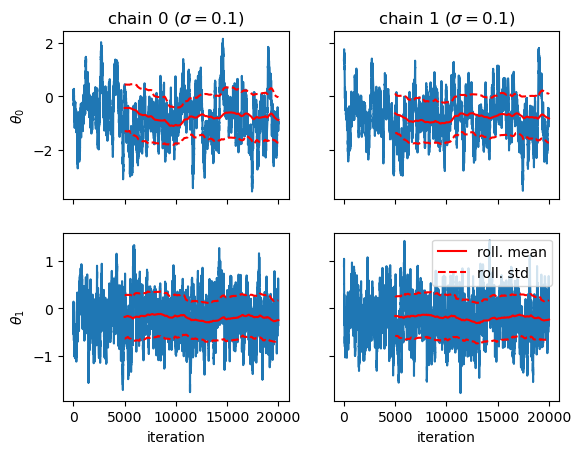

In [65]:
samplerM = emcee.EnsembleSampler(nwalkers, ndim, logpdf_secret, moves=emcee.moves.GaussianMove(np.eye(ndim)*0.1**2))
samplerM.run_mcmc(init, Nsamples)
samplesM = samplerM.get_chain()
print(f'...the average acceptance ratio is {samplerM.acceptance_fraction.mean()}')
trace_plots(samplesM[:,0,:], samplesM[:,2,:], title_str = rf'($\sigma=0.1$)', lag=lag)